<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>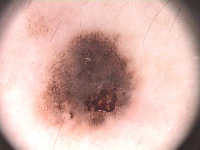</td><td>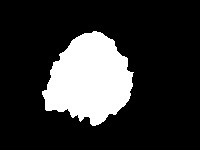</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2023-04-22 13:48:54--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2023-04-22 13:48:54--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0ec6f3324f2c23b31b08ac3008.dl.dropboxusercontent.com/cd/0/inline/B6r1ZdLnq6JRPotxas2d-9S5nzVcQAWNx3MLAoV3X34mNCWIb-aUn2KlnuT7QLdQ2JvszNrhCmABM_y740fcmrX113QYtTp-H9PwX5MlglLfXVXUXnB-owhruunkJUQcB_updDTX4bm-T5HHTYCmd7K9Sxd2_9uYqDSvURAebi4B_A/file# [following]
--2023-04-22 13:48:54--  https://uc0ec6f3324f2c23b31b08ac3008.dl.dropboxusercontent.com/cd/0/inline/B6r1ZdLnq6JRPotxas2d-9S5nzVcQAWNx3MLAoV3X34mNCWIb-aUn2KlnuT7QLdQ2JvszNrhCm

In [ ]:
!ls

PH2Dataset.rar	sample_data


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
# root = 'C:/Users/rokot/ПК/Desktop/ml/dls/HOMEWORKS/PH2Dataset/PH2Dataset'
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images') ):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

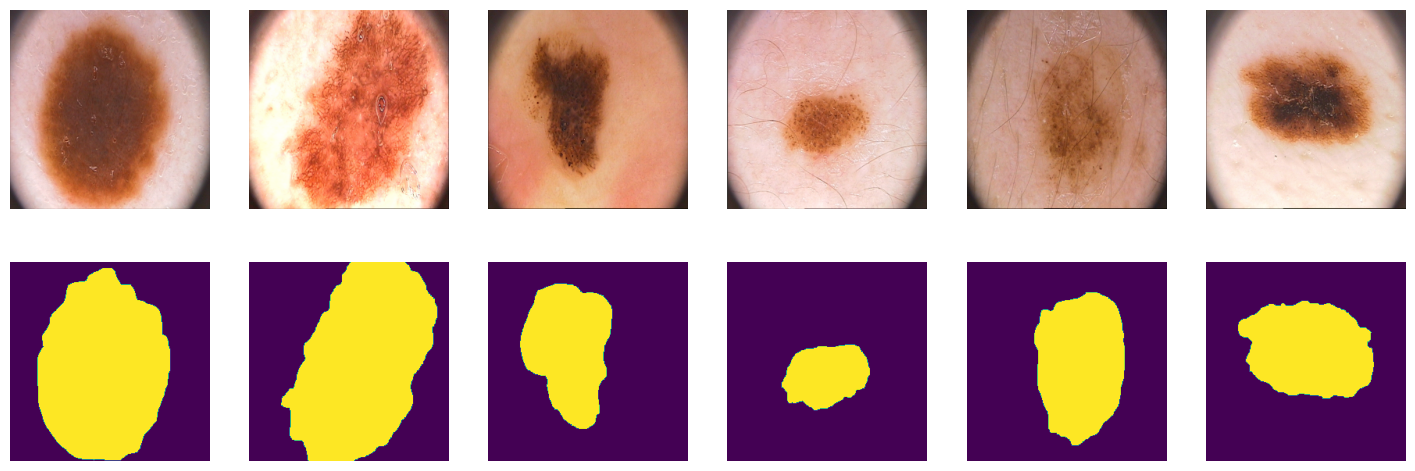

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

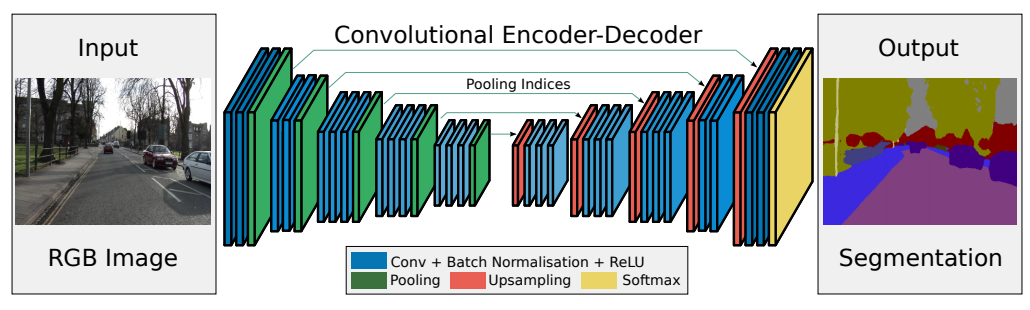

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
import seaborn as sns
rcParams['figure.figsize'] = (15,4)

In [2]:
m = nn.Sigmoid()
a = torch.randn(2)
print(a)
print(a.sigmoid())
output = m(a)
print(output)

tensor([0.2946, 0.1750])
tensor([0.5731, 0.5436])
tensor([0.5731, 0.5436])


In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2,stride=2, return_indices=True)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ) 
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=2, return_indices=True)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512,kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2,stride=2, return_indices=True)
        self.upsample = nn.MaxUnpool2d(kernel_size=2,stride=2)
        
        self.bottleneck_deconv =  nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512,kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 =  nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        # encoder
        e0, idx0 = self.pool0(self.enc_conv0(x))
        e1, idx1 = self.pool1(self.enc_conv1(e0))
        e2, idx2 = self.pool2(self.enc_conv2(e1))
        e3, idx3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b, idx4 = self.pool4(self.bottleneck_conv(e3))
        b = self.bottleneck_deconv(self.upsample(b, idx4))
        
        # decoder
        d0 = self.dec_conv0(self.upsample0(b, idx3))
        d1 = self.dec_conv1(self.upsample1(d0, idx2))
        d2 = self.dec_conv2(self.upsample2(d1, idx1))
        d3 = self.dec_conv3(self.upsample3(d2, idx0))  # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return iou.mean()

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
class BCEWithLogitsLoss(nn.Module):
    def __init__(
        self,
        reduction: str = "mean"
    ):
        super().__init__()
        self.reduction = reduction

    def forward(self, y_pred: torch.Tensor, y_real: torch.Tensor) -> torch.Tensor:
        loss = y_pred.clamp(min=0) - y_real * y_pred + torch.log(1 + torch.exp(-torch.abs(y_pred)))

        if self.reduction == "mean":
            loss = loss.mean()

        if self.reduction == "sum":
            loss = loss.sum()

        return loss


In [ ]:
# def bce_loss(y_real, y_pred):
#     # TODO 
#     # please don't use nn.BCELoss. write it from scratch
#     return nn.BCELoss(y_real, y_pred)

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    train_losses, val_losses, train_iou, val_iou = [], [], [], []

    best_epoch = 0
    best_iou = 0.0
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_train_loss = 0.0
        avg_train_iou = 0.0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            logits = model(X_batch)
            # print(Y_batch)
            # print(Y_pred)
            loss =  loss_fn(logits, Y_batch)# forward-pass
            predictions = (torch.sigmoid(logits) > 0.5).float()
            cur_train_iou = iou_pytorch(predictions, Y_batch).item()
            # print(loss)
            loss.backward()  # backward-pass
            opt.step() # update weights

            # calculate loss to show the user
            avg_train_loss += loss / len(data_tr)
            avg_train_iou += cur_train_iou / len(data_tr)
        toc = time()
        print('loss: %f' % avg_train_loss)
        avg_train_loss = avg_train_loss.cpu()
        train_losses.append(avg_train_loss.item())
        train_iou.append(avg_train_iou)

        # show intermediate results
        model.eval()  # testing mode
        avg_val_loss = 0
        avg_val_iou = 0
        with torch.no_grad():
            Y_hat = torch.sigmoid(model(X_val.to(device))).detach().cpu()      
            
            for X_batch, Y_batch in data_val:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)

                logits = model(X_batch)
                loss = loss_fn(logits, Y_batch)
                avg_val_loss += loss / len(data_val)
                
                predictions = (torch.sigmoid(logits) > 0.5).float()
                cur_val_iou = iou_pytorch(predictions, Y_batch).item()
                avg_val_iou += cur_val_iou / len(data_val)

            avg_val_loss = avg_val_loss.cpu()
            val_losses.append(avg_val_loss.item())
            val_iou.append(avg_val_iou)

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_train_loss))
        plt.show()
    
    result_dict = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        "train_iou": train_iou,
        'val_iou': val_iou
    }
    
    del X_batch
    del Y_batch
    del logits
    del loss

    torch.cuda.empty_cache()
    return result_dict

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    with torch.no_grad():
      Y_pred = [ (torch.sigmoid(model(X_batch.to(device))) > 0.5).float().cpu() for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_label = Y_label.to(device)
        with torch.no_grad():
            Y_pred = (torch.sigmoid(model(X_batch)) > 0.5).float()
            scores += metric(Y_pred, Y_label) / len(data)

    del X_batch
    del Y_label
    del Y_pred
    torch.cuda.empty_cache()

    return scores

In [ ]:
def plot_hist(history, name):
    
    fig, axs = plt.subplots(1, 2, figsize = (20,10))
    sns.lineplot(ax = axs[0], y = history['train_losses'], x =[x for x in range(len(history['train_losses']))], label = "train_loss")
    sns.lineplot(ax = axs[0], y = history['val_losses'], x =[x for x in range(len(history['val_losses']))],  label = "val_loss")
    axs[0].set_title('Loss')

    sns.lineplot(ax = axs[1], y = history['train_iou'], x =[x for x in range(len(history['train_iou']))], label = "train_iou")
    sns.lineplot(ax = axs[1], y = history['val_iou'], x =[x for x in range(len(history['val_iou']))], label = "val_iou")
    axs[1].set_title('iou')
    plt.suptitle(name)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
model = SegNet().to(device)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()
!nvidia-smi

Sat Apr 22 13:49:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    29W /  70W |    723MiB / 15360MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

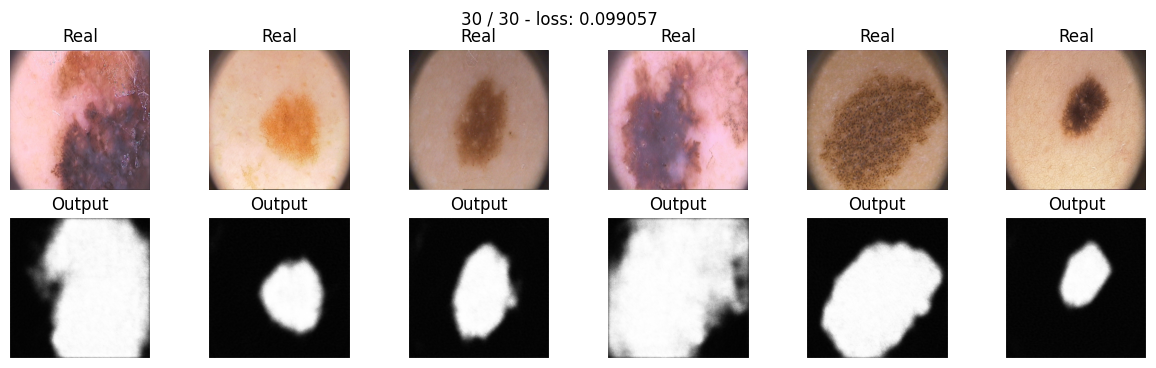

In [ ]:
max_epochs = 30
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
history_bce = train(model, optim, BCEWithLogitsLoss(), max_epochs, data_tr, data_val)

In [ ]:
unet2_bce_test_iou = score_model(model, iou_pytorch, data_ts).cpu().item() # вспомнил об этом только в конце, поэтому название перменной странное, так как вствалял снизу вверх, короче здесь и далее за скор отвечает unet2_bce_test_iou
history_bce['test'] = unet2_bce_test_iou

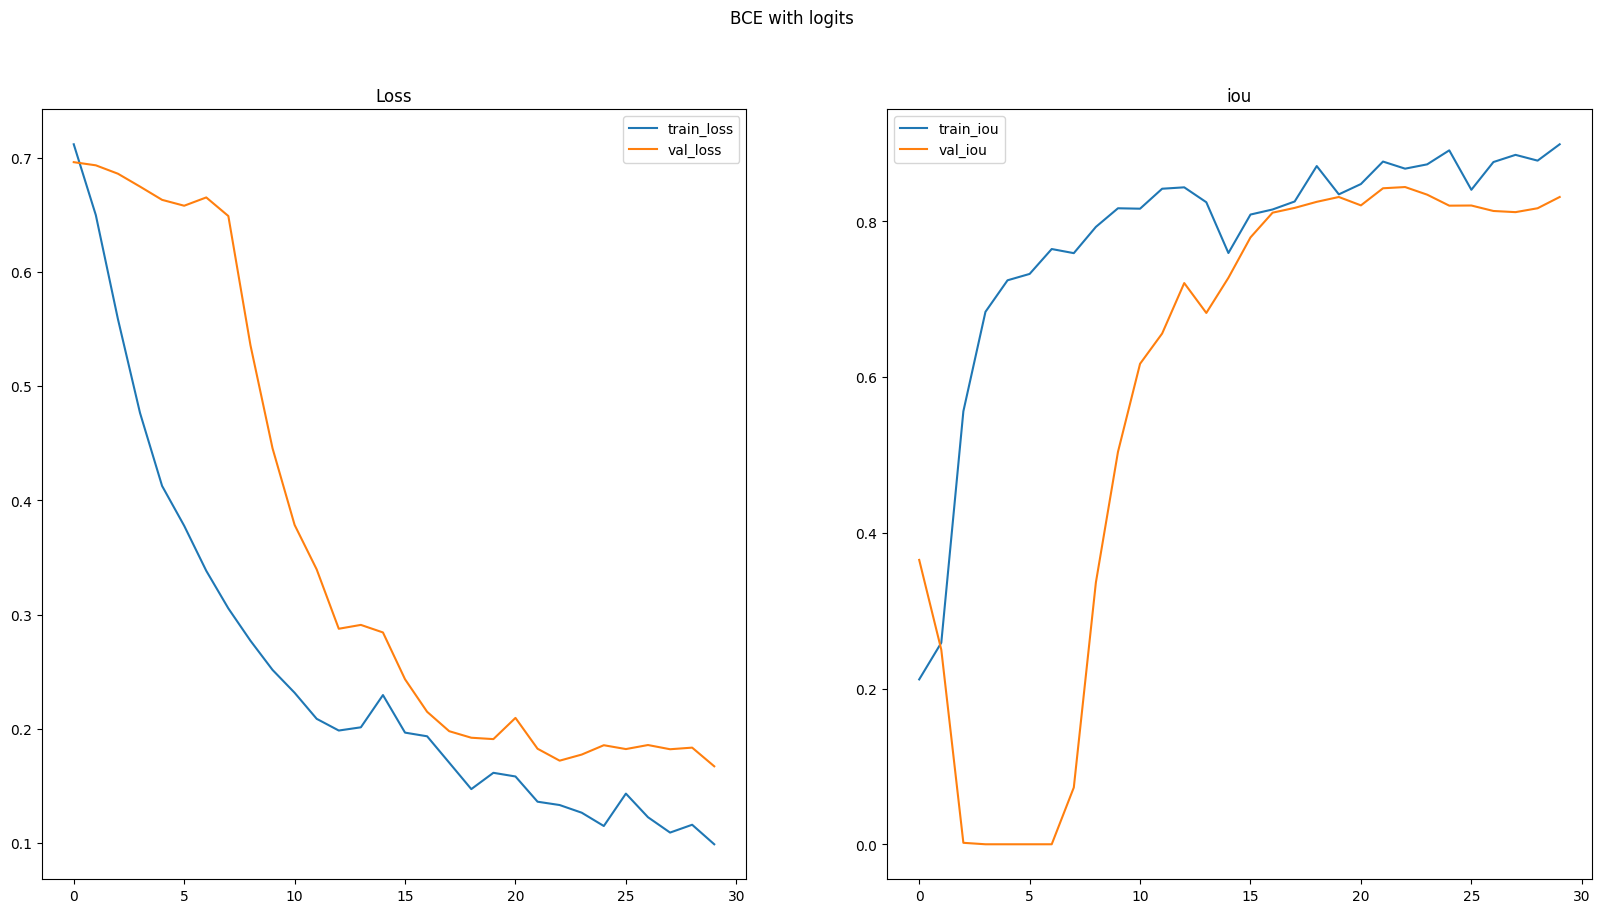

In [ ]:
plot_hist(history_bce, "BCE with logits")

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

81208

Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
class DiceLoss(nn.Module):
    def __init__(
        self,
        eps: float = 1e-8
    ):
        super().__init__()
        self.eps = eps

    def forward(self, y_pred, y_real):
        y_pred = torch.sigmoid(y_pred.squeeze(1))
        y_real = y_real.squeeze(1)

        num = 2.0 * (y_real * y_pred).sum((1, 2))
        den = (y_real + y_pred).sum((1, 2))
        res = 1 -  ((num + self.eps) / (den + self.eps)).sum() / y_real.size(0)
        return res

Проводим тестирование:

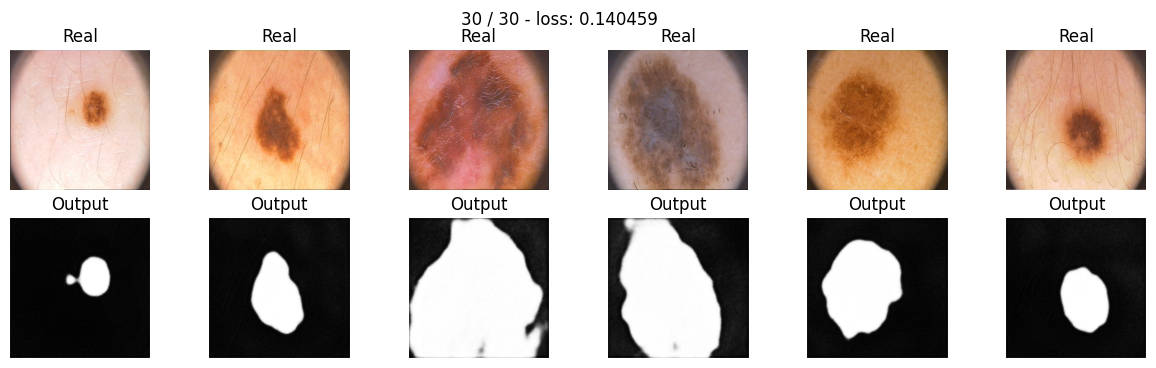

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 30
optimaizer = torch.optim.Adam(model_dice.parameters(),lr=1e-4)
dice_loss = DiceLoss()
history_dice = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
unet2_bce_test_iou = score_model(model_dice, iou_pytorch, data_ts).cpu().item()
history_dice['test'] = unet2_bce_test_iou

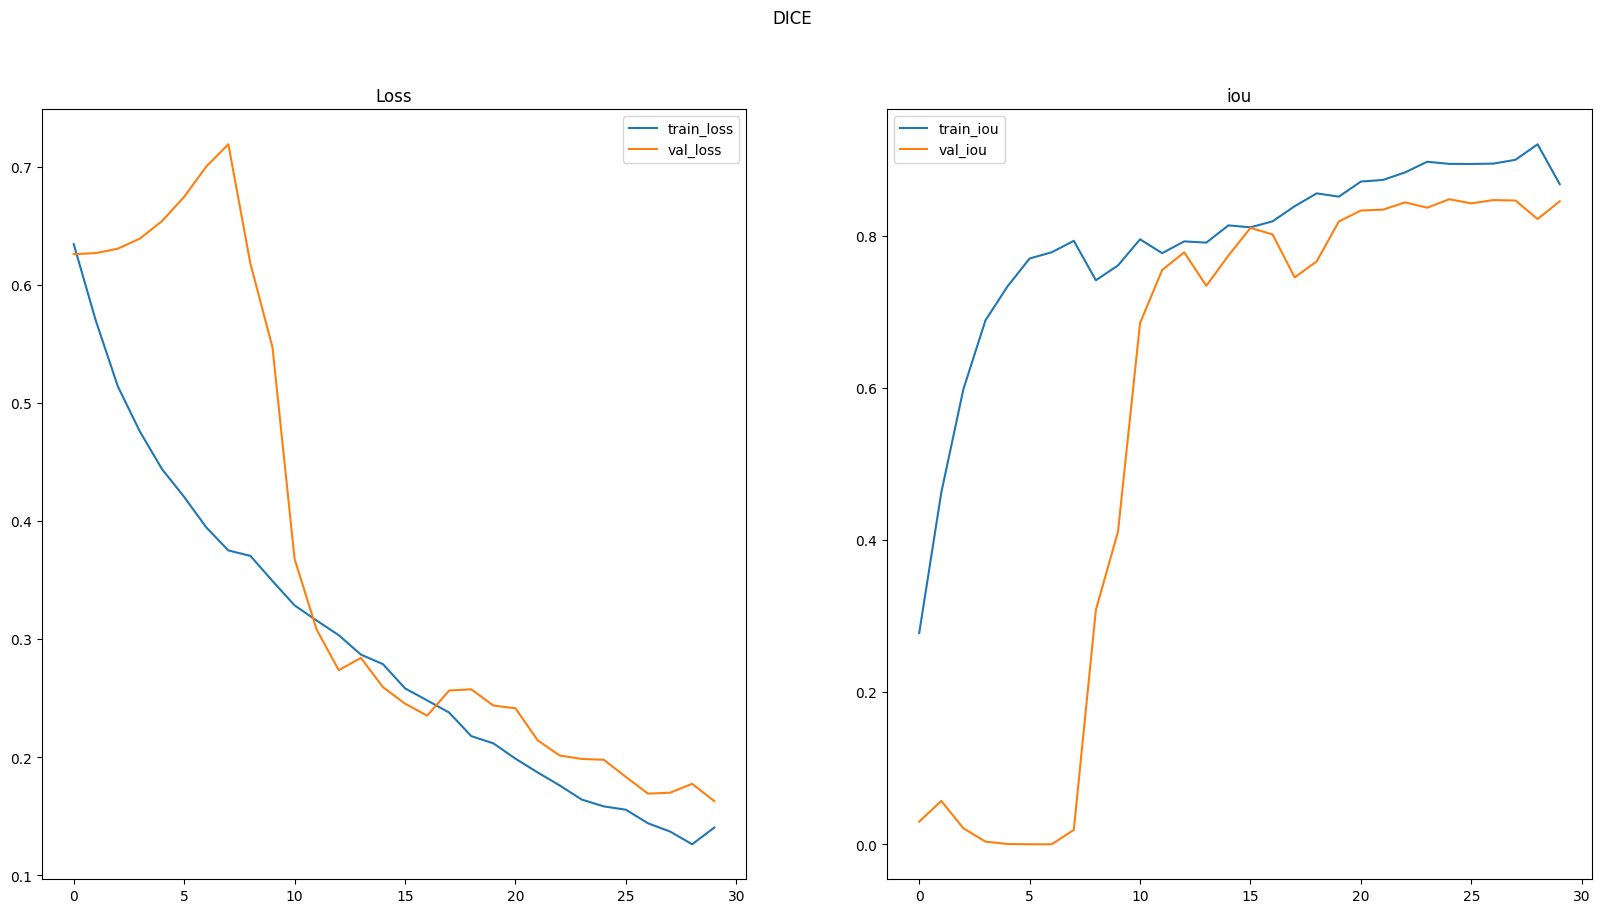

In [ ]:
plot_hist(history_dice, "DICE")

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
class focal_loss(nn.Module):

  def __init__(self, eps=1e-8, gamma=2):
    super().__init__()
    self.eps = eps
    self.gamma = gamma

  def forward(self, y_pred, y_real):
      y_pred = torch.clamp(torch.sigmoid(y_pred), min=self.eps, max=1 - self.eps)
      loss = (1 - y_pred) ** self.gamma * y_real * torch.log(y_pred) + (1 - y_real) * torch.log(1 - y_pred)
      return -loss.mean()


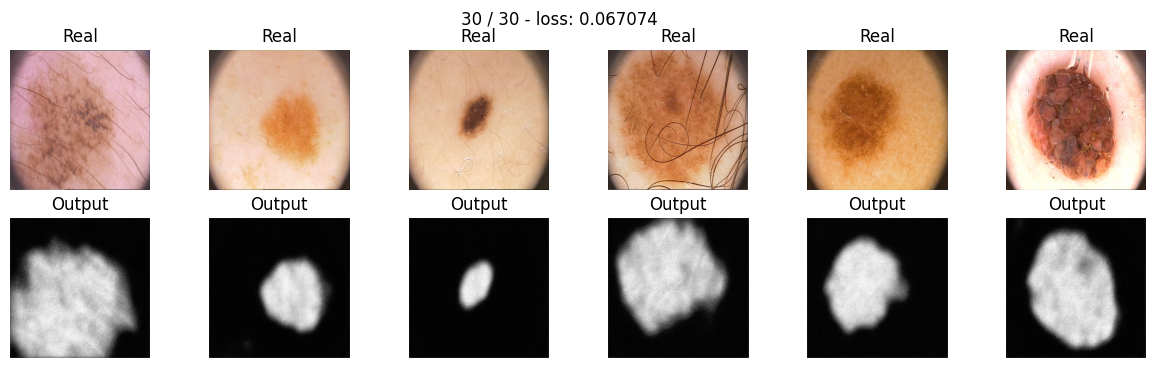

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 30
optimaizer = torch.optim.Adam(model_focal.parameters(), lr=1e-4)
loss = focal_loss()
history_focal = train(model_focal, optimaizer, loss, max_epochs, data_tr, data_val)

In [ ]:
unet2_bce_test_iou = score_model(model_focal, iou_pytorch, data_ts).cpu().item()
history_focal['test'] = unet2_bce_test_iou

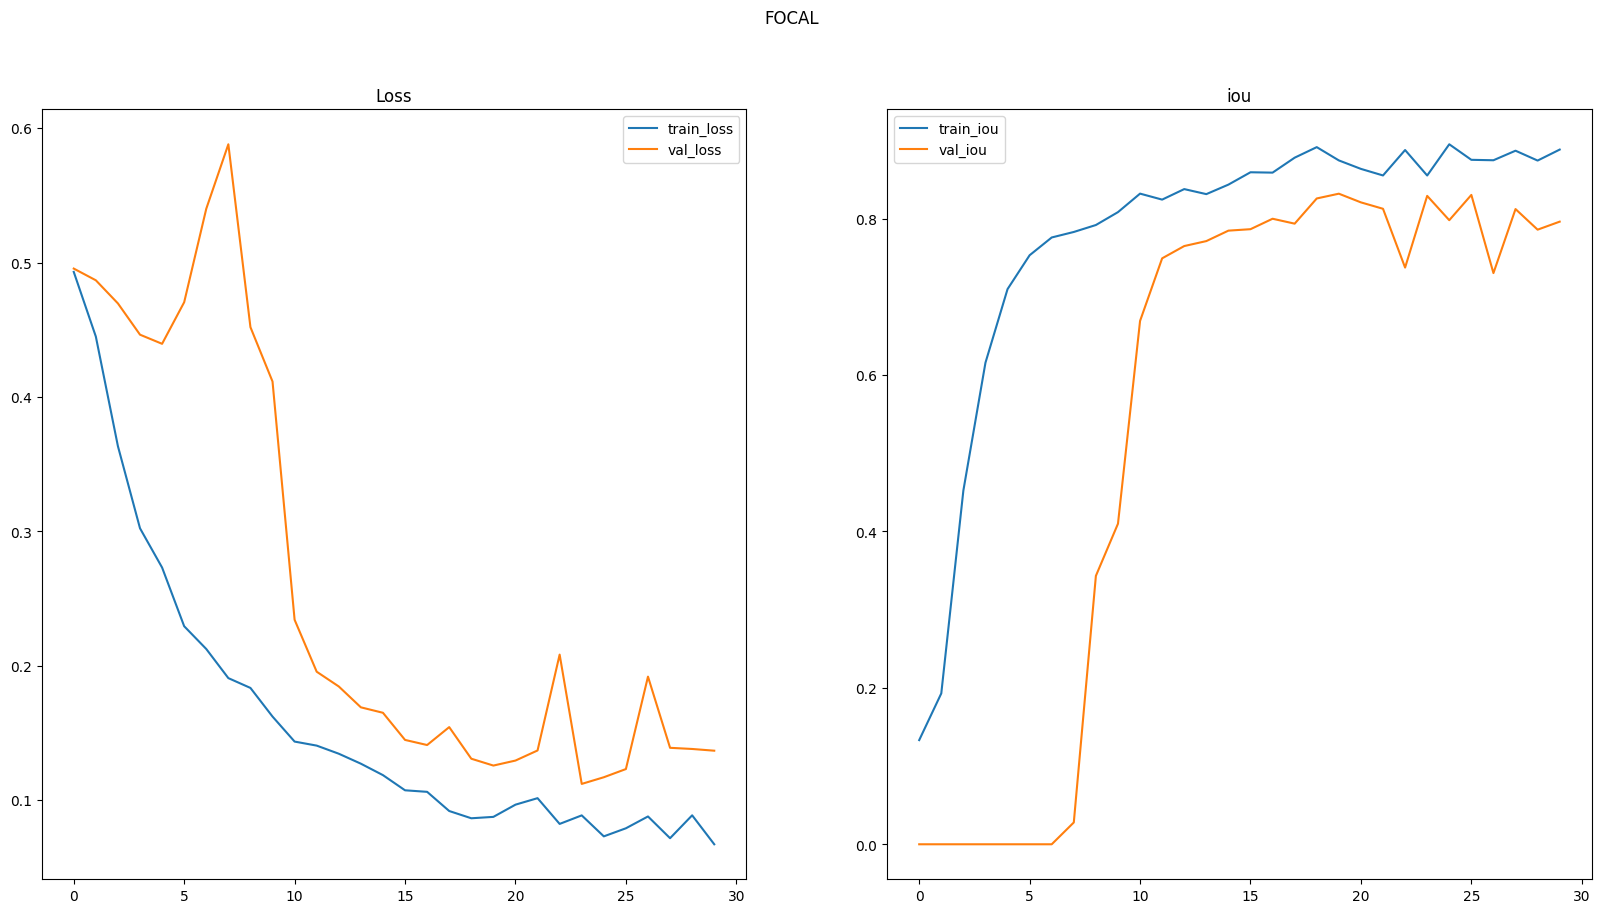

In [ ]:
plot_hist(history_focal, "FOCAL")

----------------------------------------------------------------------------------------------

## Мир сегментационных лоссов 

In [ ]:
class JaccardLoss(nn.Module):
    def __init__(
        self,
        eps: float = 1e-8
    ):
        super().__init__()
        self.eps = eps

    def forward(self, y_pred, y_real):
        y_pred = torch.sigmoid(y_pred.squeeze(1))
        y_real = y_real.squeeze(1)

        num = 2.0 * (y_real * y_pred).sum((1, 2))
        den = (y_real + y_pred).sum((1, 2))
        dice = 1 -  ((num + self.eps) / (den + self.eps)).sum() / y_real.size(0)
        return dice / (2 - dice)

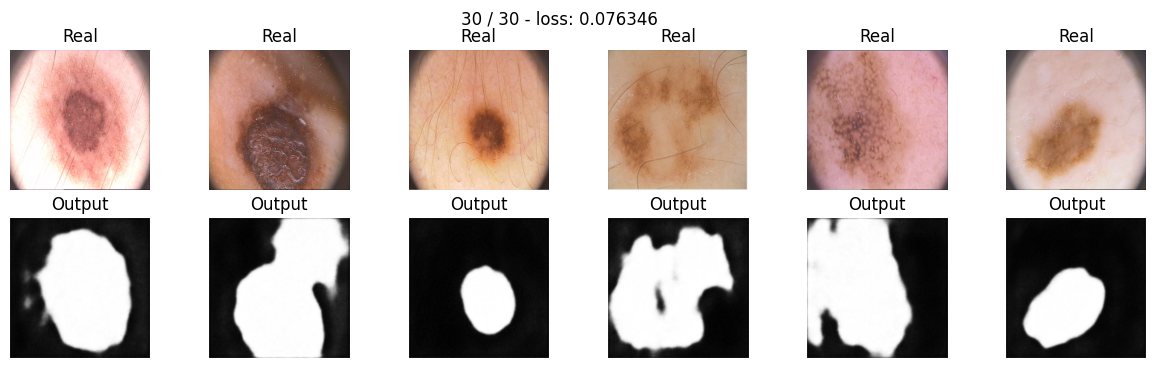

In [ ]:
model_Jaccard = SegNet().to(device)

max_epochs = 30
optimaizer = torch.optim.Adam(model_Jaccard.parameters(), lr=1e-4)
loss = JaccardLoss()
history_jaccrad = train(model_Jaccard, optimaizer, loss, max_epochs, data_tr, data_val)

In [ ]:
unet2_bce_test_iou = score_model(model_Jaccard, iou_pytorch, data_ts).cpu().item()
history_jaccrad['test'] = unet2_bce_test_iou

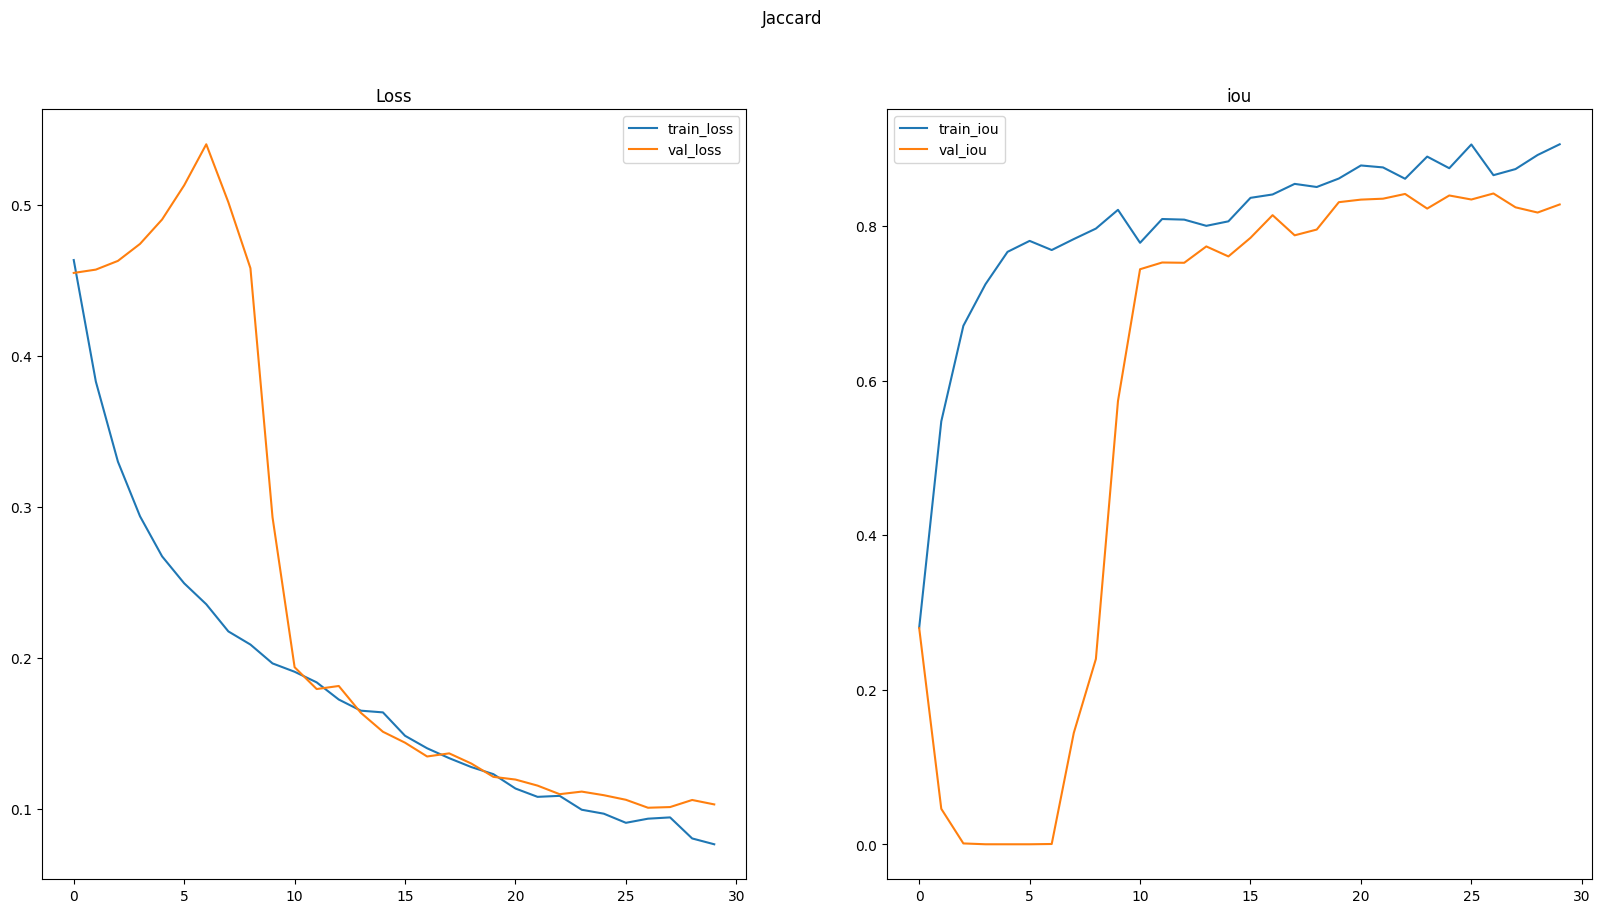

In [ ]:
plot_hist(history_jaccrad, "Jaccard")

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

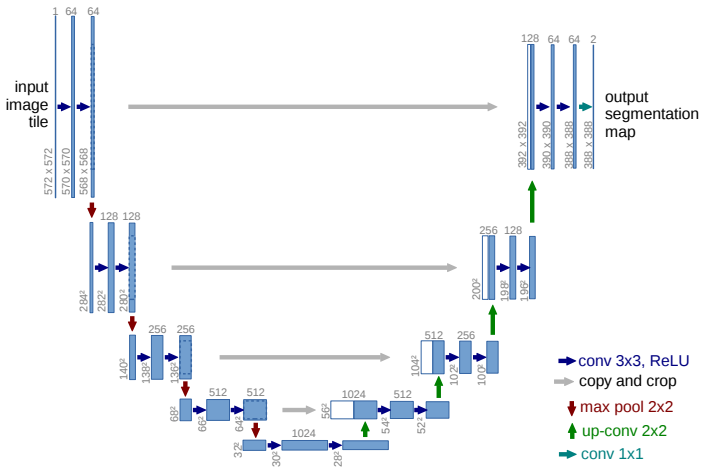

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ) 
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=2)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024,kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512,kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )


        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.Upsample(scale_factor=2)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.Upsample(scale_factor=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_conv3 =  nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=1, kernel_size=1)
            )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0 = self.pool0(e0)
        
        e1 = self.enc_conv1(p0)
        p1 = self.pool1(e1)
        
        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)
        
        e3 = self.enc_conv3(p2)
        p3 = self.pool3(e3)

        # bottleneck
        b =  self.upsample0(self.bottleneck_conv(p3))

        # decoder
        d0 = self.upsample1(self.dec_conv0(torch.cat([b, e3], dim=1)))
        d1 = self.upsample2(self.dec_conv1(torch.cat([d0, e2], dim=1)))
        d2 = self.upsample3(self.dec_conv2(torch.cat([d1, e1], dim=1)))
        d3 = self.dec_conv3(torch.cat([d2, e0], dim=1))
        return d3

In [ ]:
unet_model = UNet().to(device)

In [ ]:
loss = BCEWithLogitsLoss()

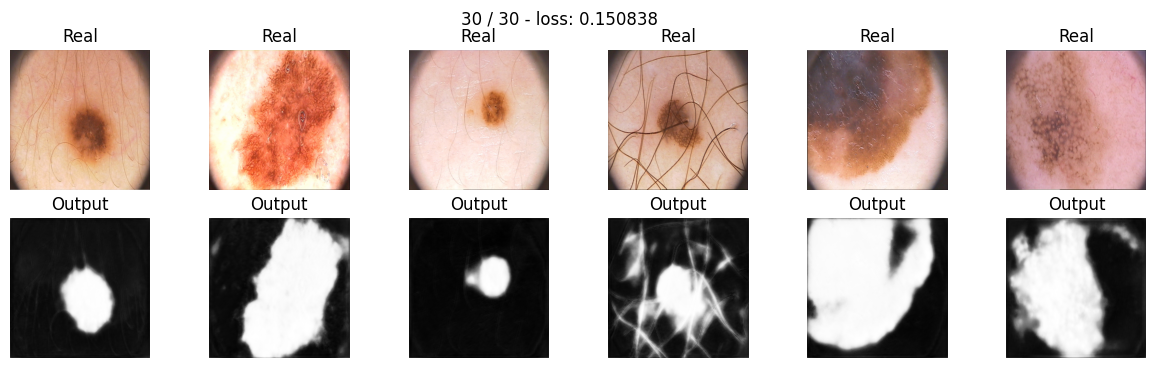

In [ ]:
history_unet_bce = train(unet_model, torch.optim.Adam(unet_model.parameters(), lr=1e-4), loss, 30, data_tr, data_val)

In [ ]:
unet2_bce_test_iou = score_model(unet_model, iou_pytorch, data_ts).cpu().item()
history_unet_bce['test'] = unet2_bce_test_iou

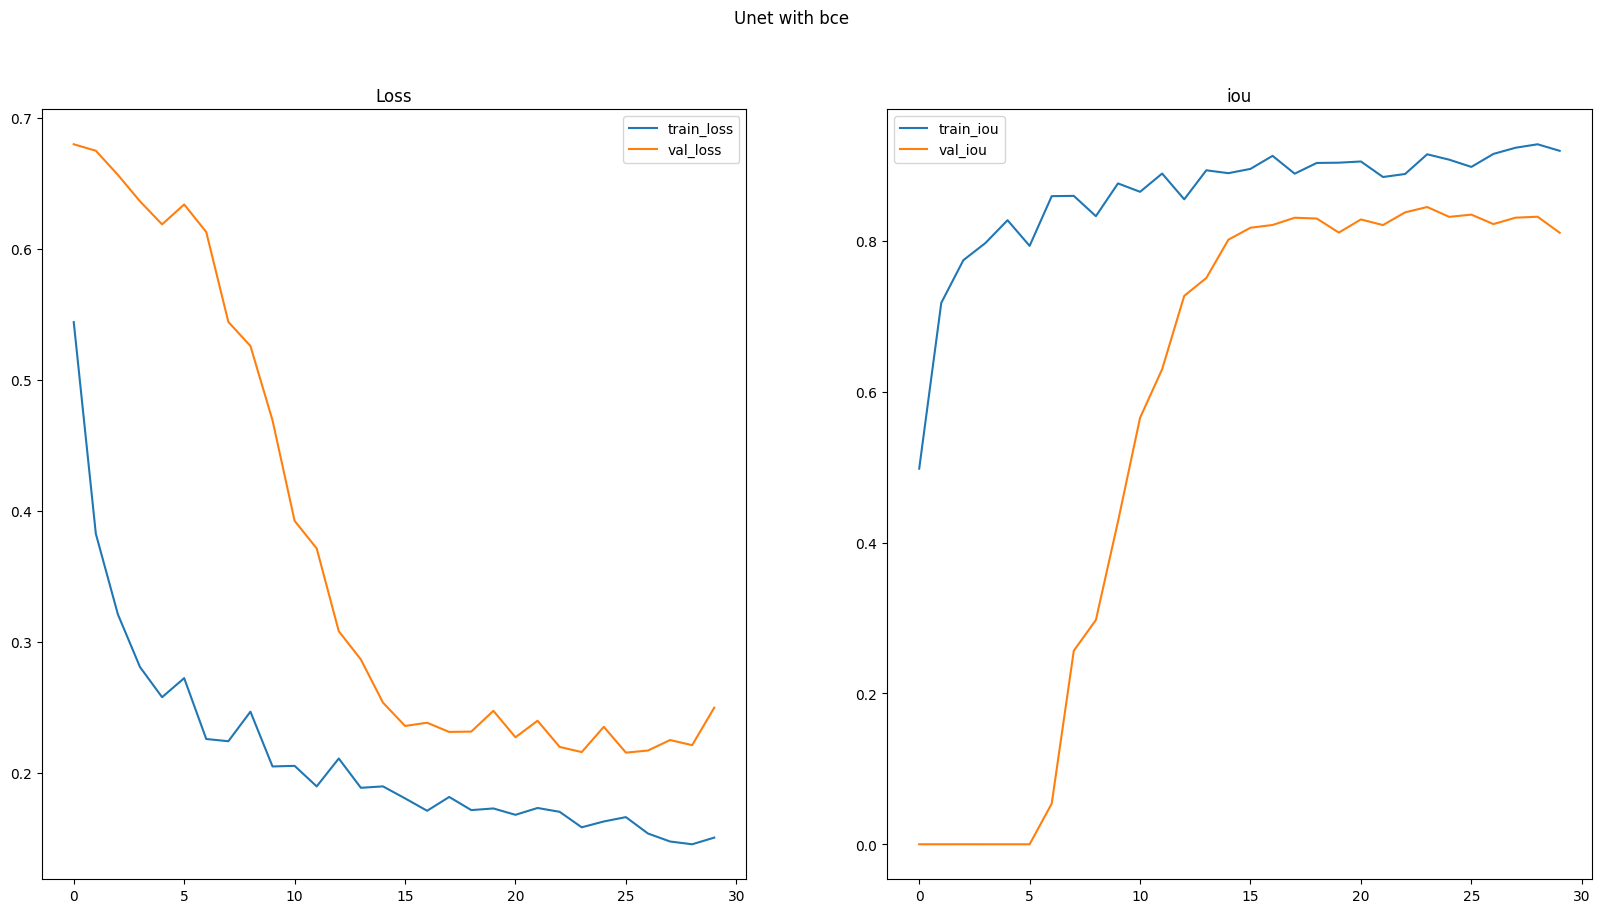

In [ ]:
plot_hist(history_unet_bce, "Unet with bce")

In [ ]:
unet_dice = UNet().to(device)
loss = DiceLoss()

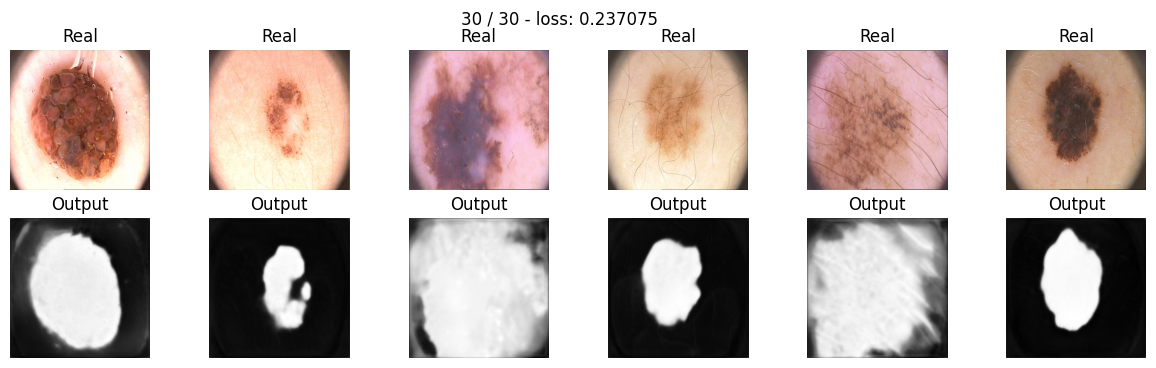

In [ ]:
history_unet_dice = train(unet_dice, torch.optim.Adam(unet_dice.parameters(), lr=1e-4), loss, 30, data_tr, data_val)

In [ ]:
unet2_bce_test_iou = score_model(unet_dice, iou_pytorch, data_ts).cpu().item()
history_unet_dice['test'] = unet2_bce_test_iou

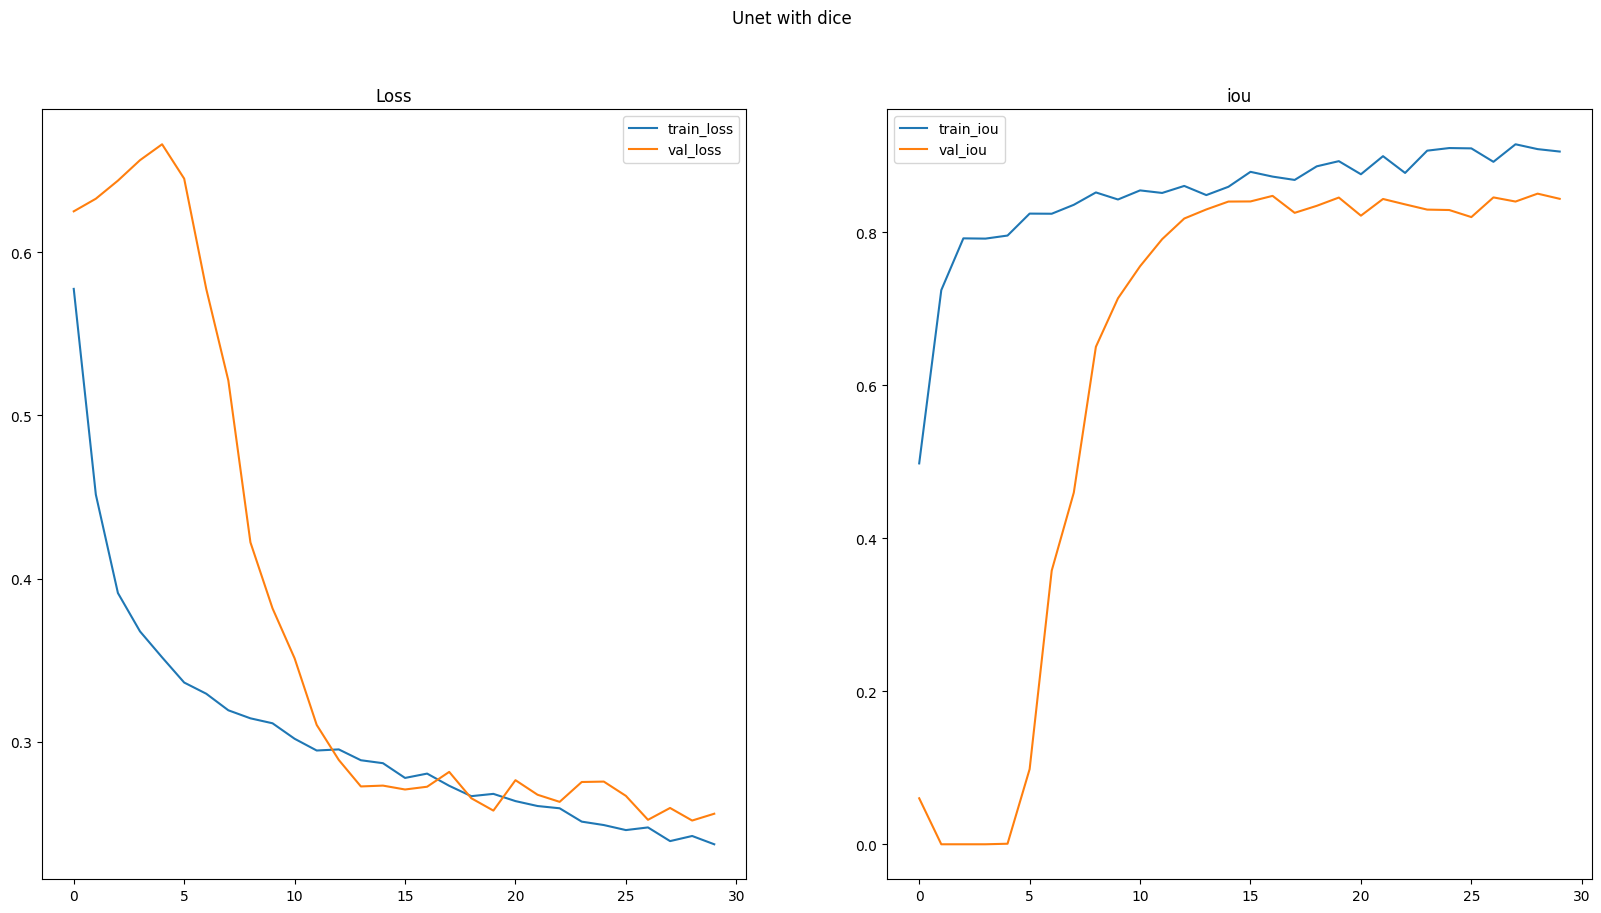

In [ ]:
plot_hist(history_unet_dice, "Unet with dice")

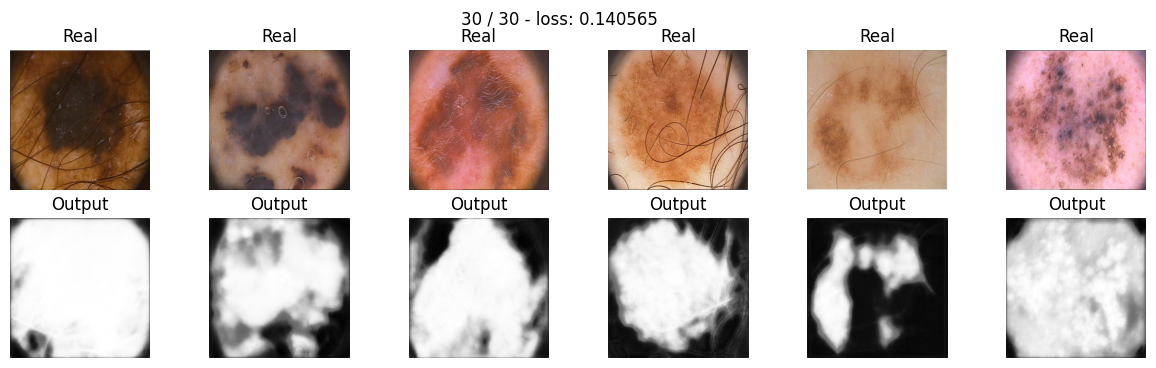

In [ ]:
unet_model_focal = UNet().to(device)

max_epochs = 30
optimaizer = torch.optim.Adam(unet_model_focal.parameters(), lr=1e-4)
loss = focal_loss()
history_unet_focal = train(unet_model_focal, optimaizer, loss, max_epochs, data_tr, data_val)

In [ ]:
unet2_bce_test_iou = score_model(unet_model_focal, iou_pytorch, data_ts).cpu().item()
history_unet_focal['test'] = unet2_bce_test_iou

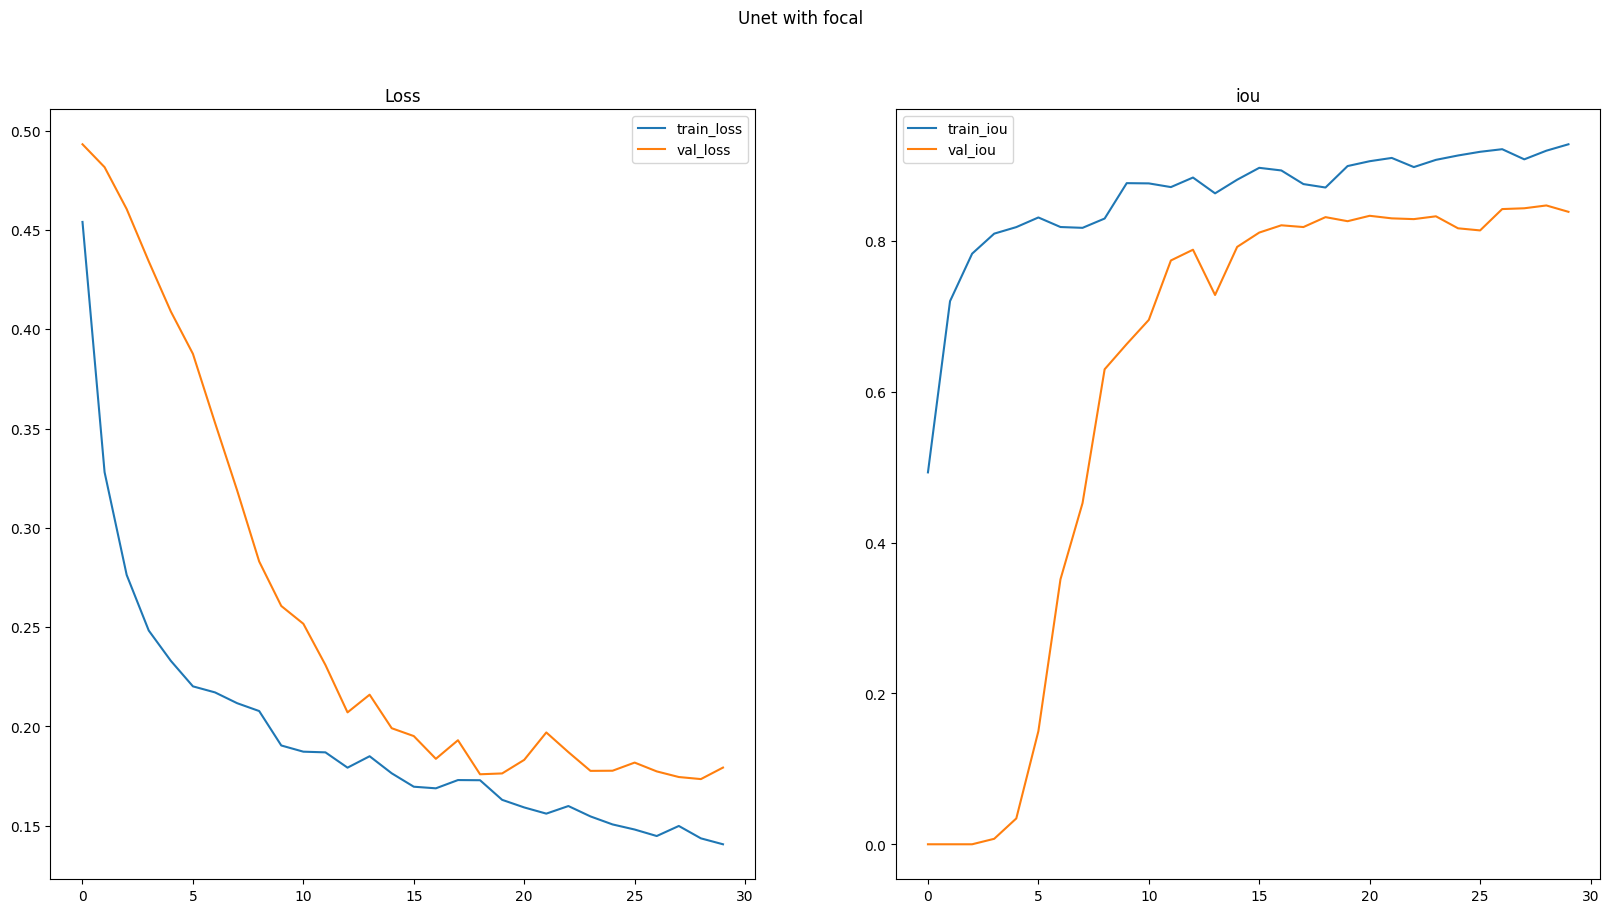

In [ ]:
plot_hist(history_unet_focal, "Unet with focal")

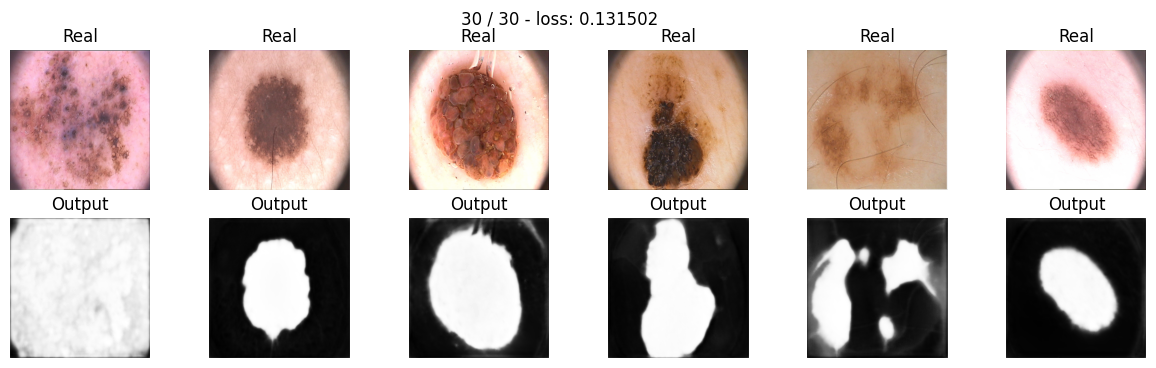

In [ ]:
unet_model_jac = UNet().to(device)

max_epochs = 30
optimaizer = torch.optim.Adam(unet_model_jac.parameters(), lr=1e-4)
loss = JaccardLoss()
history_unet_jac = train(unet_model_jac, optimaizer, loss, max_epochs, data_tr, data_val)

In [ ]:
unet2_bce_test_iou = score_model(unet_model_jac, iou_pytorch, data_ts).cpu().item()
history_unet_jac['test'] = unet2_bce_test_iou

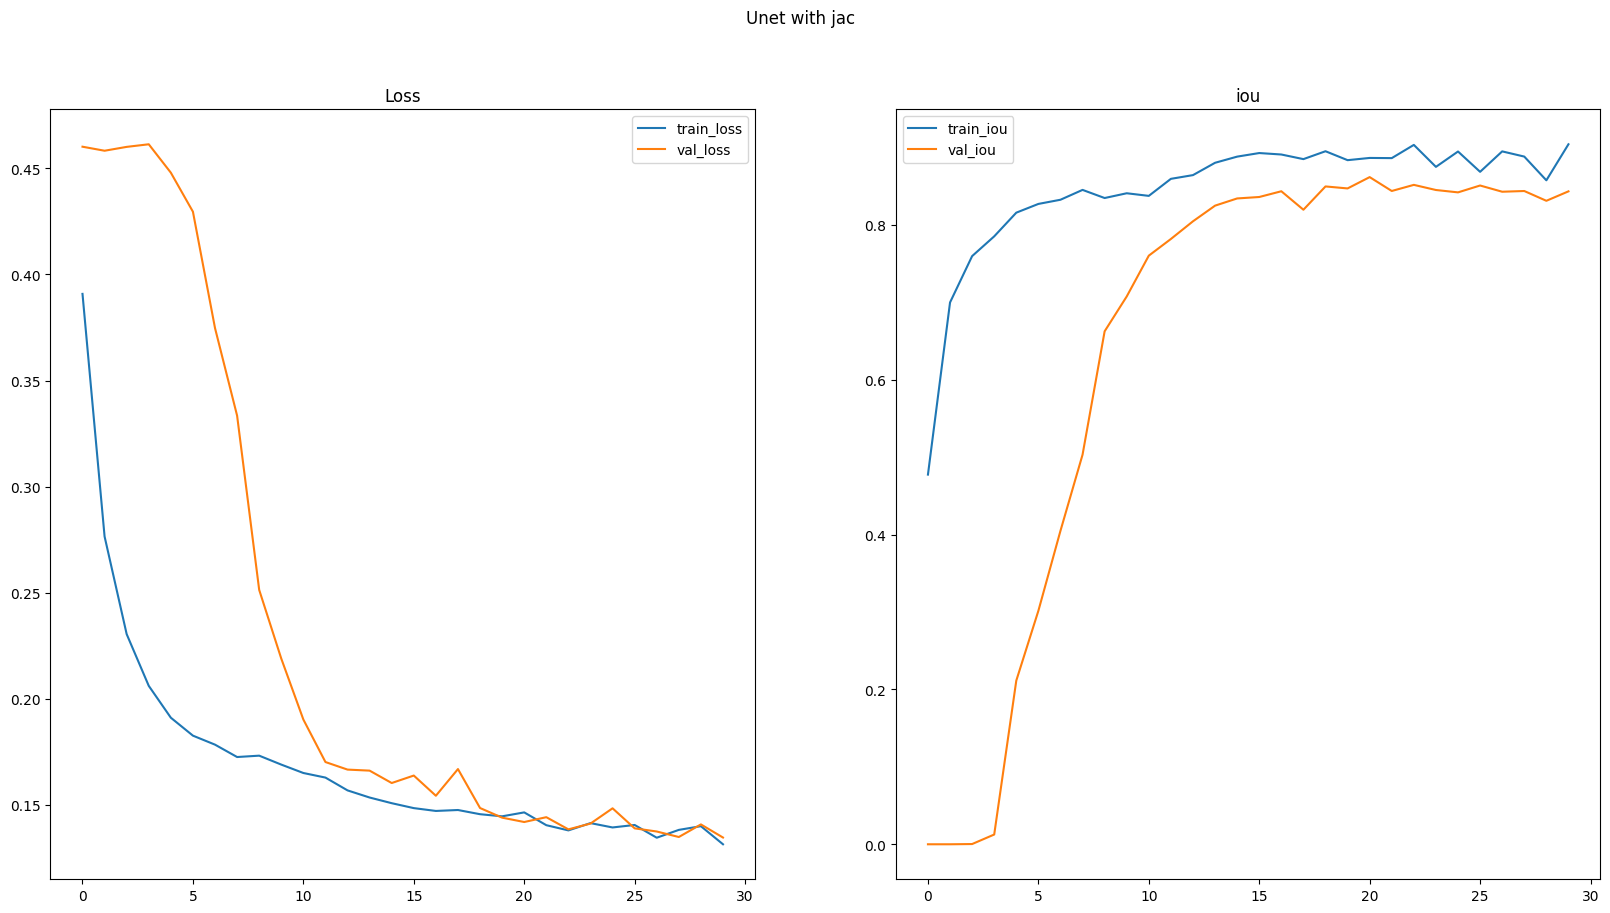

In [ ]:
plot_hist(history_unet_jac, "Unet with jac")

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(UNet):
    def __init__(self):
      super().__init__()
      self.pool0 = nn.Conv2d(64, 64, kernel_size=2,stride=2)
      self.pool1 = nn.Conv2d(128, 128, kernel_size=2,stride=2)
      self.pool2 = nn.Conv2d(256, 256, kernel_size=2,stride=2)
      self.pool3 = nn.Conv2d(512, 512, kernel_size=2,stride=2)

      self.upsample0 = nn.ConvTranspose2d(512, 512, kernel_size=2,stride=2)
      self.upsample1 = nn.ConvTranspose2d(256, 256, kernel_size=2,stride=2)
      self.upsample2 = nn.ConvTranspose2d(128, 128, kernel_size=2,stride=2)
      self.upsample3 = nn.ConvTranspose2d(64, 64, kernel_size=2,stride=2)

In [ ]:
unet2_model = UNet2().to(device)
loss = BCEWithLogitsLoss()

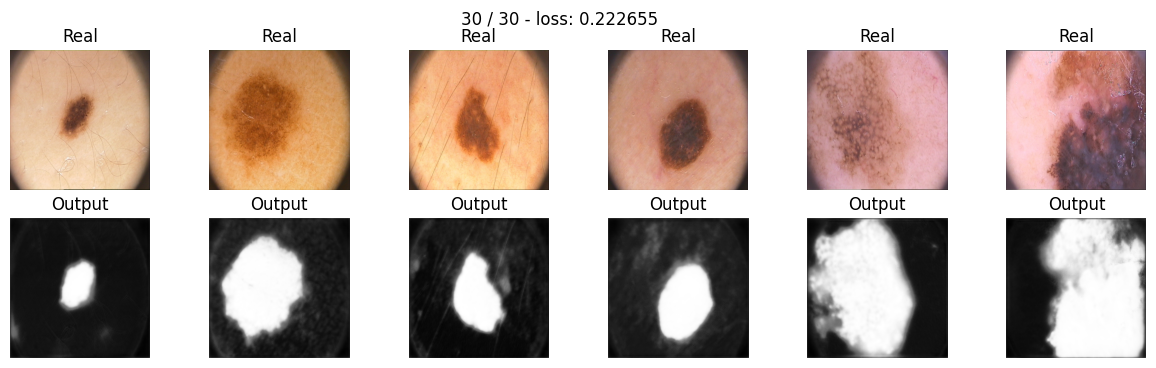

In [ ]:
history_unet2_bce = train(unet2_model, torch.optim.Adam(unet2_model.parameters(),lr=1e-4), loss, 30, data_tr, data_val)

In [ ]:
unet2_bce_test_iou = score_model(unet2_model, iou_pytorch, data_ts).cpu().item()
history_unet2_bce['test'] = unet2_bce_test_iou

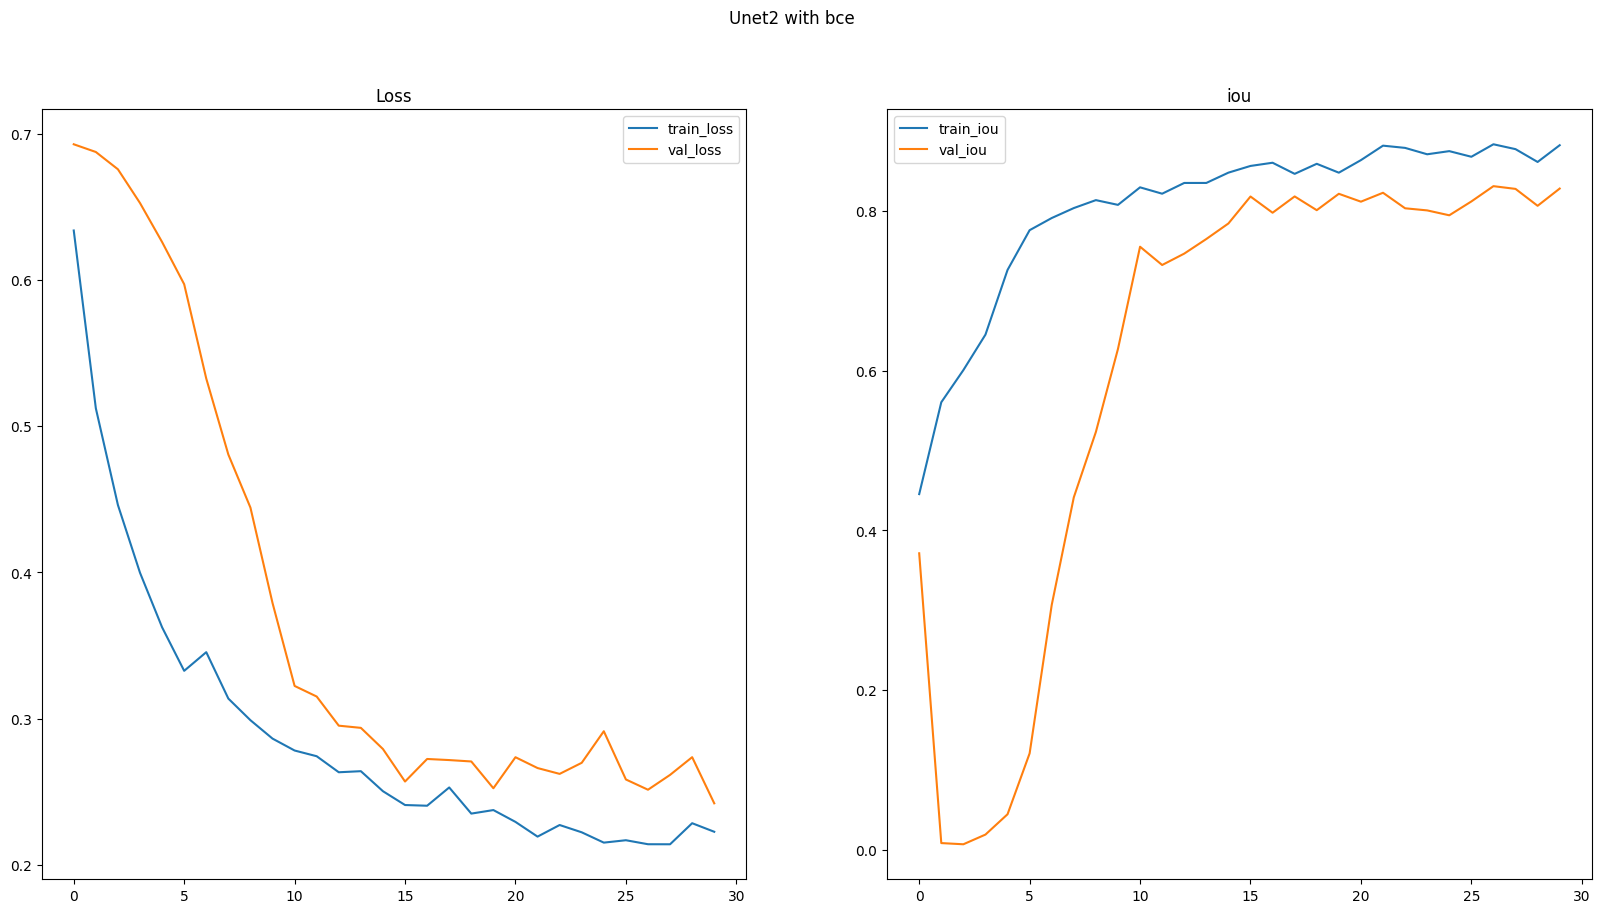

In [ ]:
plot_hist(history_unet2_bce, "Unet2 with bce")

In [ ]:
unet2_model_dice = UNet2().to(device)
loss = DiceLoss()

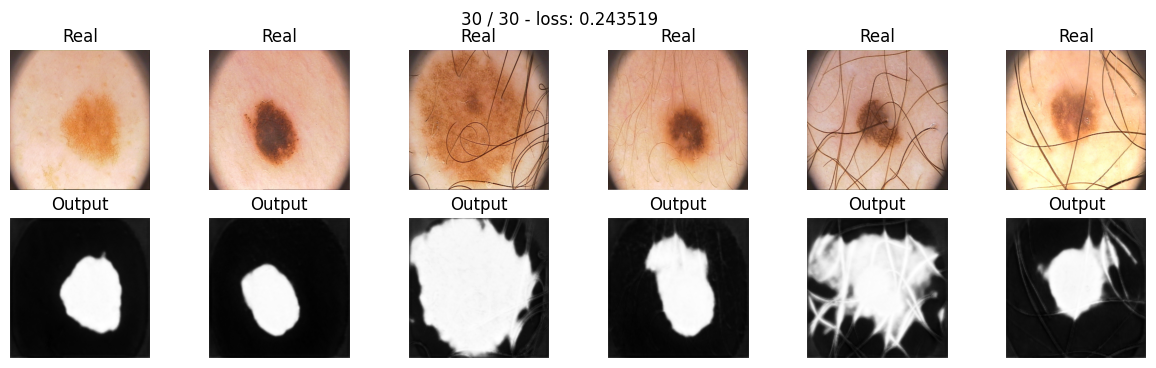

In [ ]:
history_unet2_dice = train(unet2_model_dice, torch.optim.Adam(unet2_model_dice.parameters(),lr=1e-4), loss, 30, data_tr, data_val)

In [ ]:
unet2_bce_test_iou = score_model(unet2_model_dice, iou_pytorch, data_ts).cpu().item()
history_unet2_dice['test'] = unet2_bce_test_iou

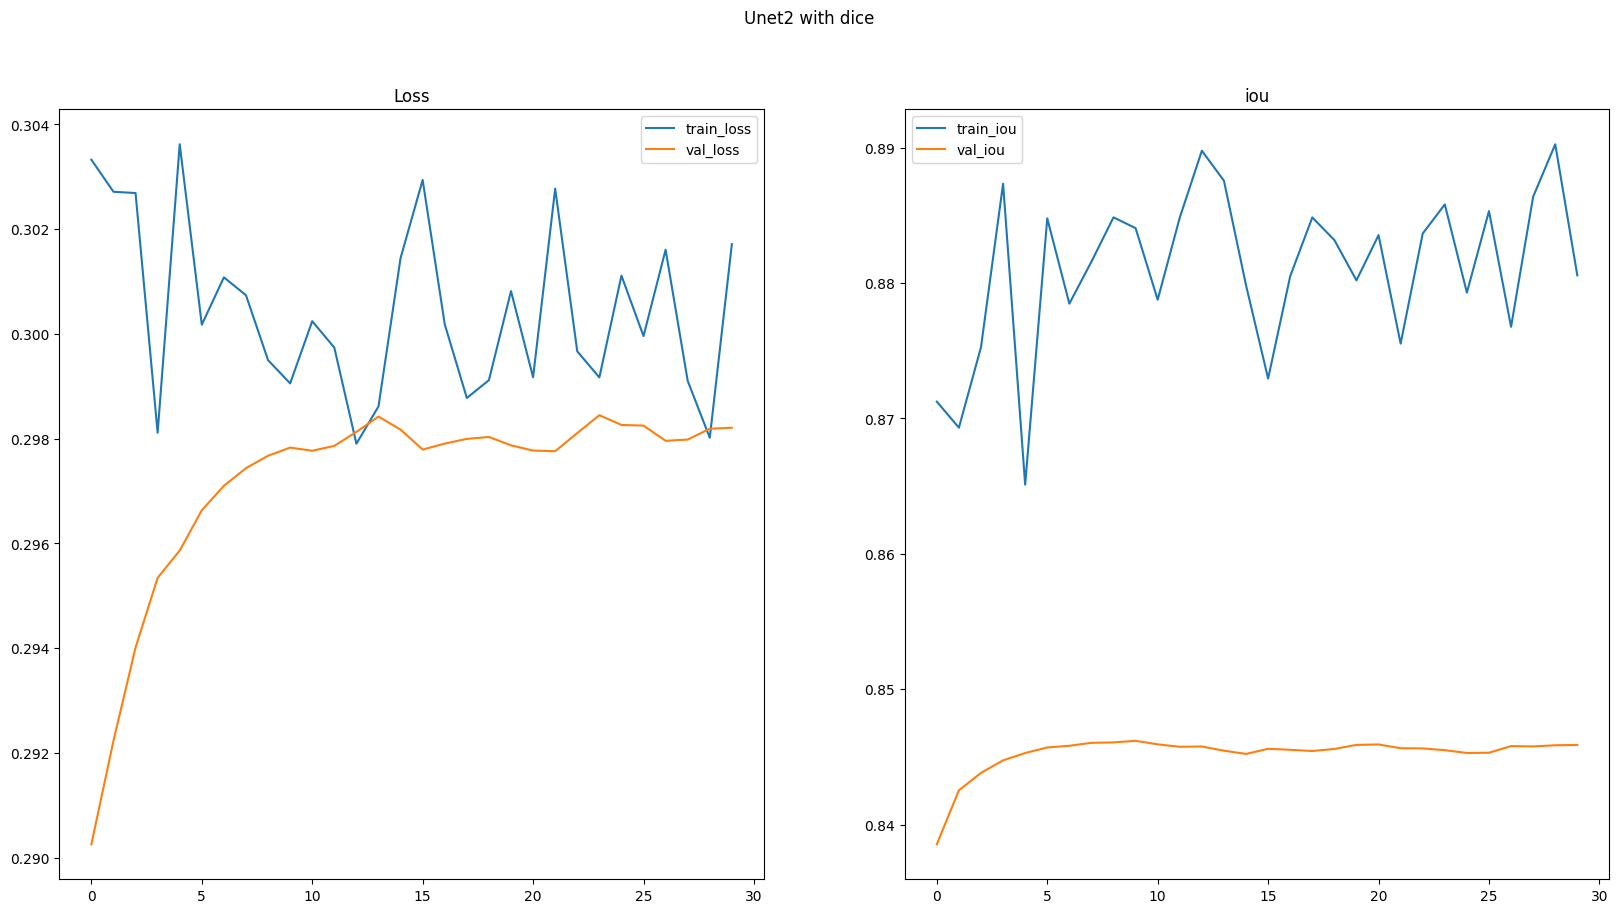

In [ ]:
plot_hist(history_unet2_dice, "Unet2 with dice")

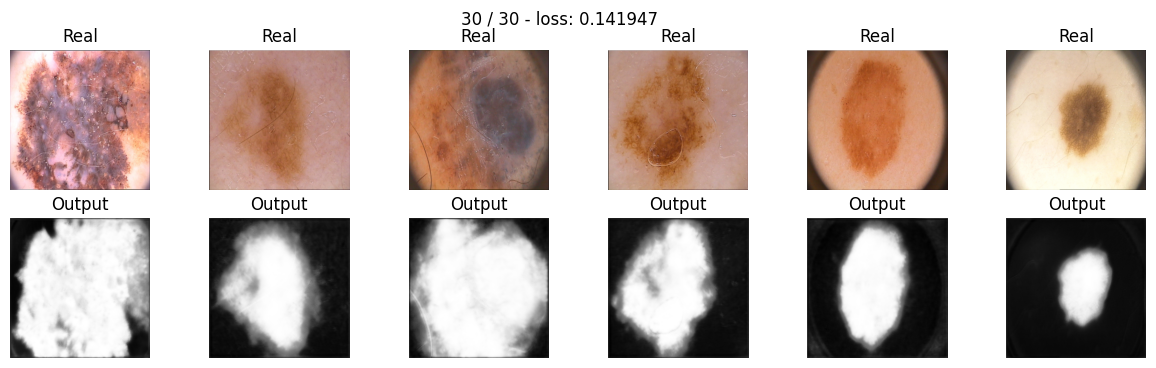

In [ ]:
unet2_model = UNet2().to(device)

max_epochs = 30
optimaizer = torch.optim.Adam(unet2_model.parameters(), lr=1e-4)
loss = focal_loss()
history_unet2_focal = train(unet2_model, optimaizer, loss, max_epochs, data_tr, data_val)

In [ ]:
unet2_bce_test_iou = score_model(unet2_model, iou_pytorch, data_ts).cpu().item()
history_unet2_focal['test'] = unet2_bce_test_iou

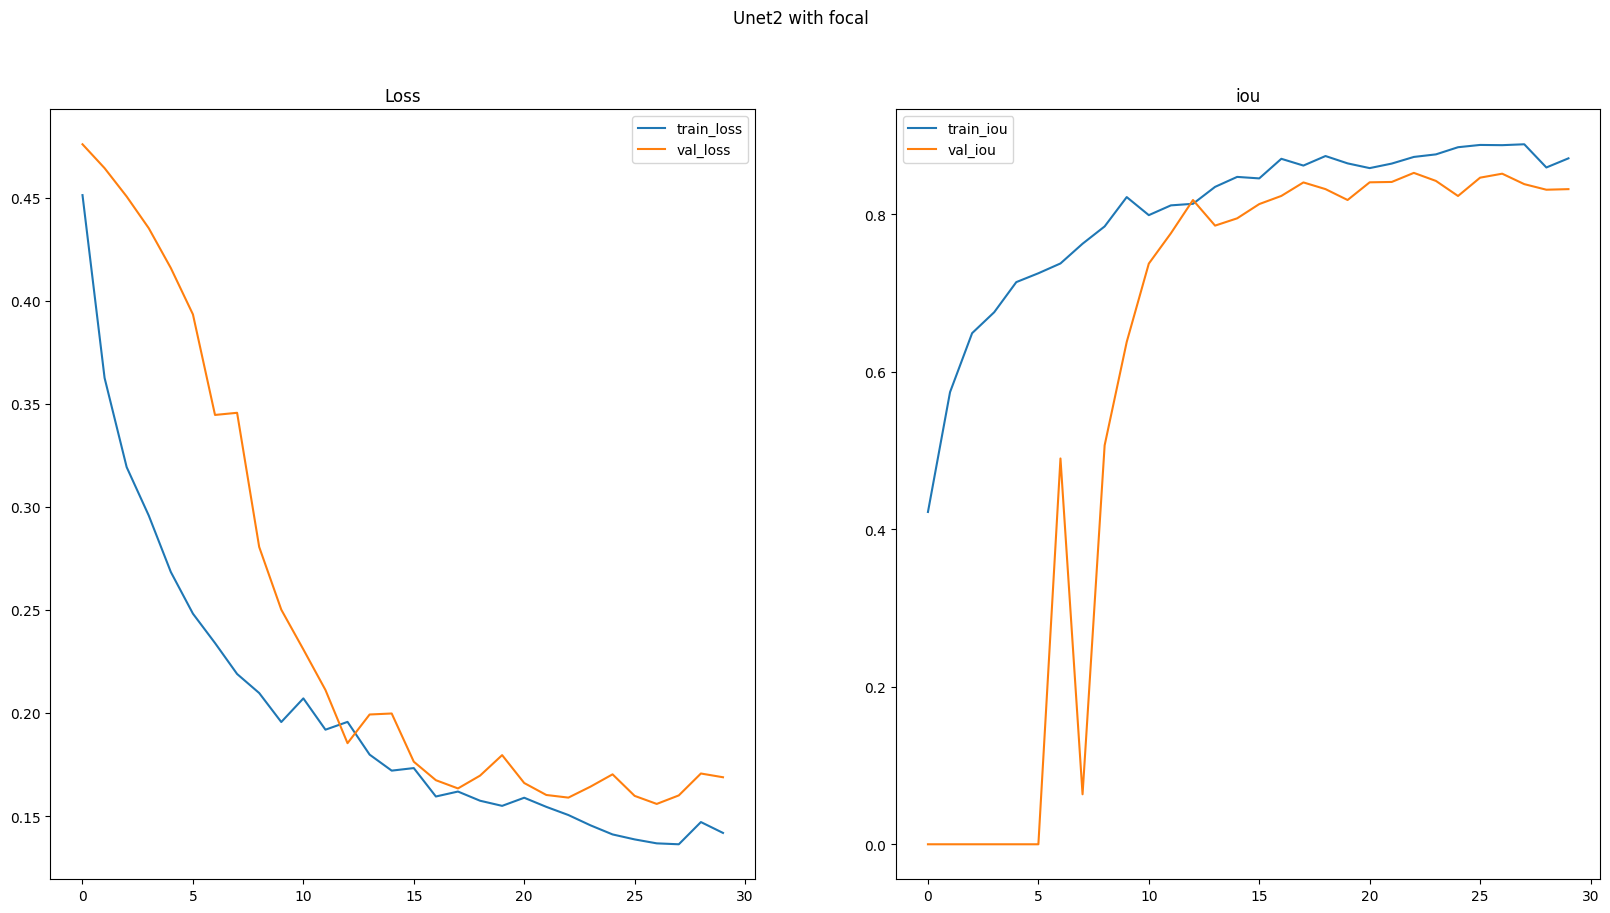

In [ ]:
plot_hist(history_unet2_focal, "Unet2 with focal")

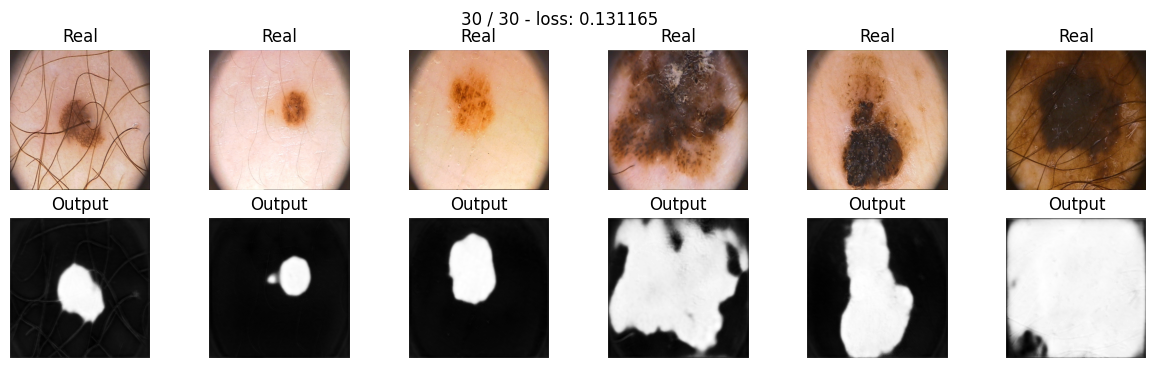

In [ ]:
unet2_model_jac = UNet2().to(device)

max_epochs = 30
optimaizer = torch.optim.Adam(unet2_model_jac.parameters(), lr=1e-4)
loss = JaccardLoss()
history_unet2_jac = train(unet2_model_jac, optimaizer, loss, max_epochs, data_tr, data_val)

In [ ]:
unet2_bce_test_iou = score_model(unet2_model_jac, iou_pytorch, data_ts).cpu().item()
history_unet2_jac['test'] = unet2_bce_test_iou

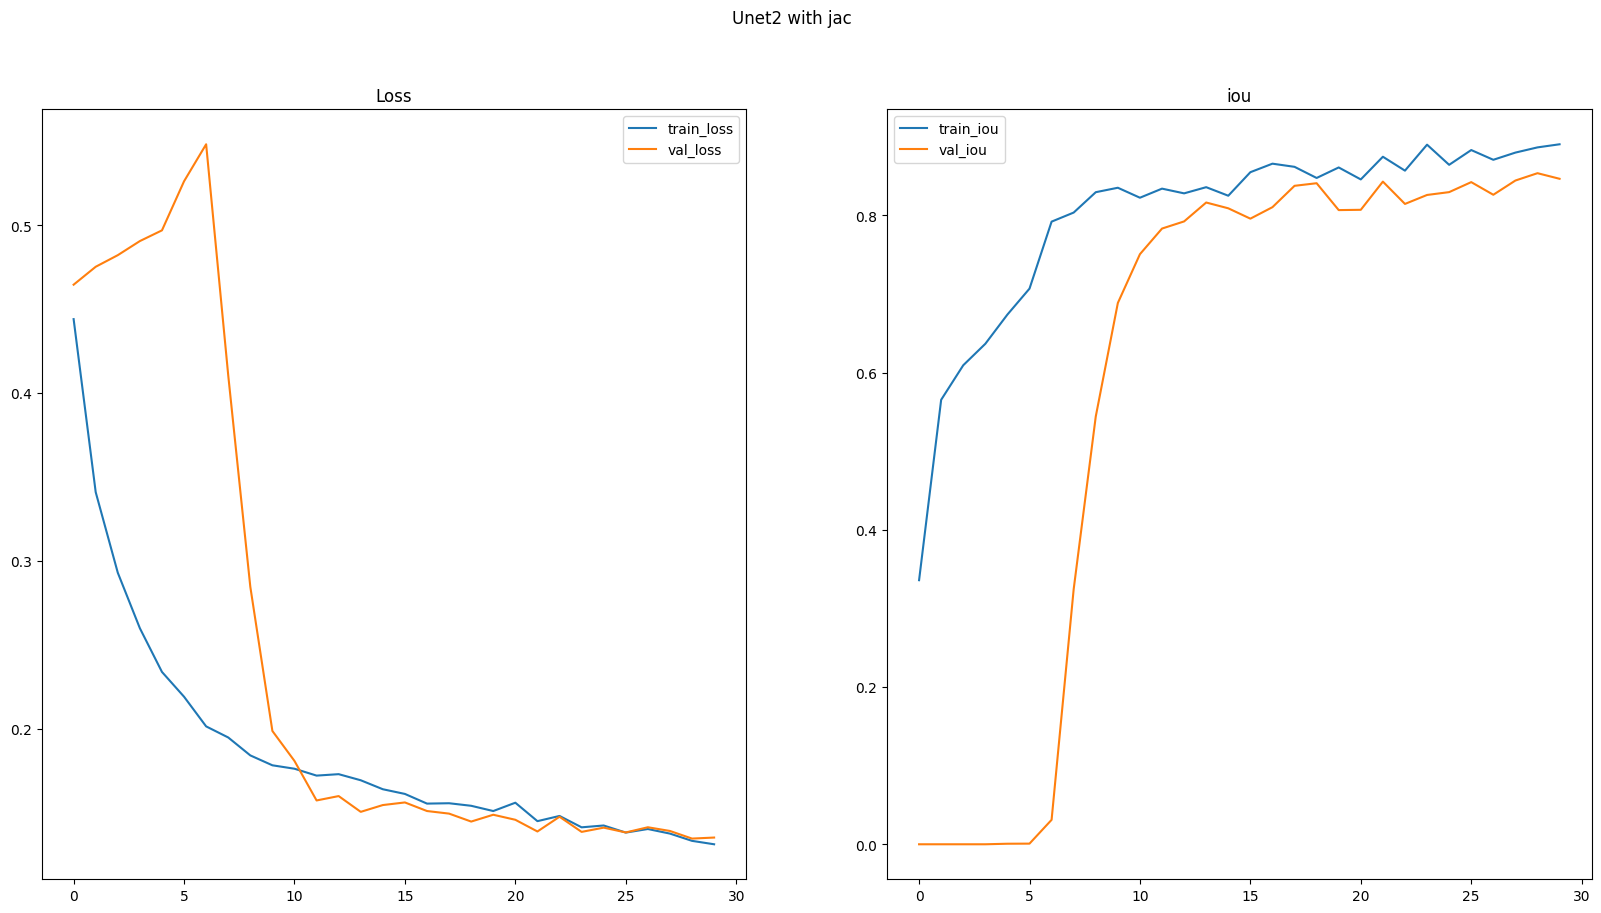

In [ ]:
plot_hist(history_unet2_jac, "Unet2 with jac")

Сделайте вывод, какая из моделей лучше

# Отчет 

In [8]:
def metr(history, desc):
    fig, axs = plt.subplots(1, 3, figsize = (20,10))
    for name in history.keys():
        sns.lineplot(ax = axs[0], y = history[name]['train_losses'], x =[x for x in range(len(history[name]['train_losses']))], label = name)
        axs[0].set_title('Loss on train')
        sns.lineplot(ax = axs[1], y = history[name]['val_losses'], x =[x for x in range(len(history[name]['val_losses']))],  label = name)
        axs[1].set_title('Loss on val')
    axs[2] = sns.barplot(x=list(history.keys()), y=[i['test'] for i in history.values()])
    axs[2].set_title('IOU on test')
        
    plt.suptitle(desc)

In [ ]:
segnet_models = {
    'BCE': history_bce,
    'DICE': history_dice,
    'FOCAL': history_focal,
    'JACCARD': history_jaccrad
}

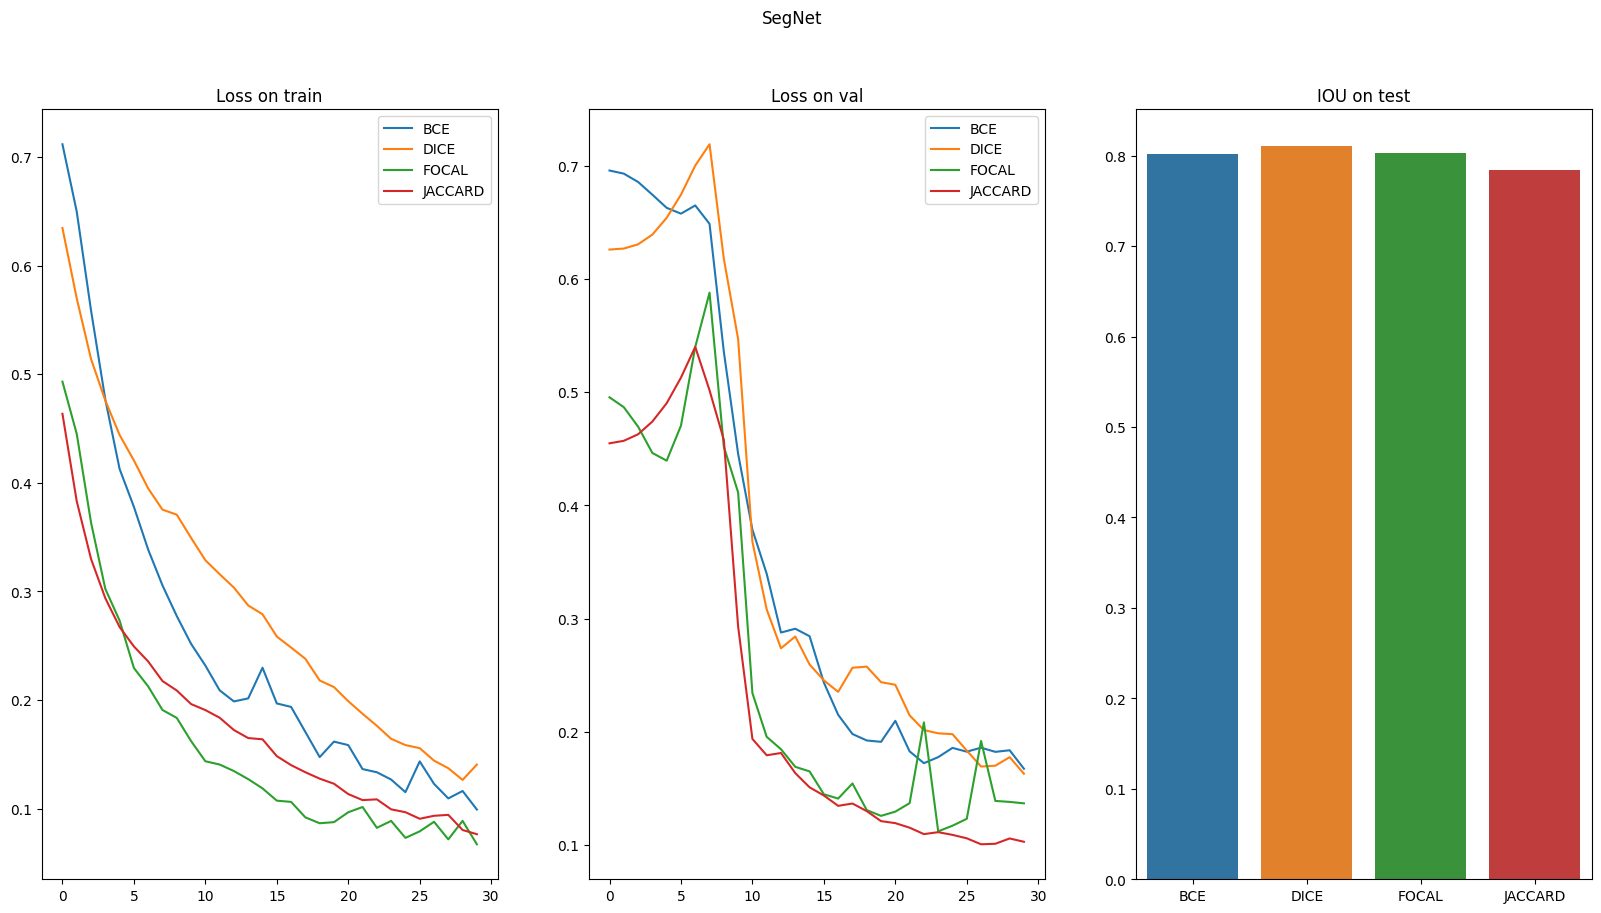

In [ ]:
metr(segnet_models, "SegNet")

Как можно видеть из графиков выше, в лидеры выбились две функции потерь *Jaccard* и *Focal*, а вот *Bce* и *Dice* уступают в среднем на 0.1 пункт. При этом *Jaccard* и *Focal* уже с первых эпох лучше, чем их соперники.

**Победители**


1.   *Jaccard*
2.   *Focal*



In [ ]:
unet_models = {
    'BCE': history_unet_bce,
    'DICE': history_unet_dice,
    'FOCAL': history_unet_focal,
    'JACCARD': history_unet_jac
}

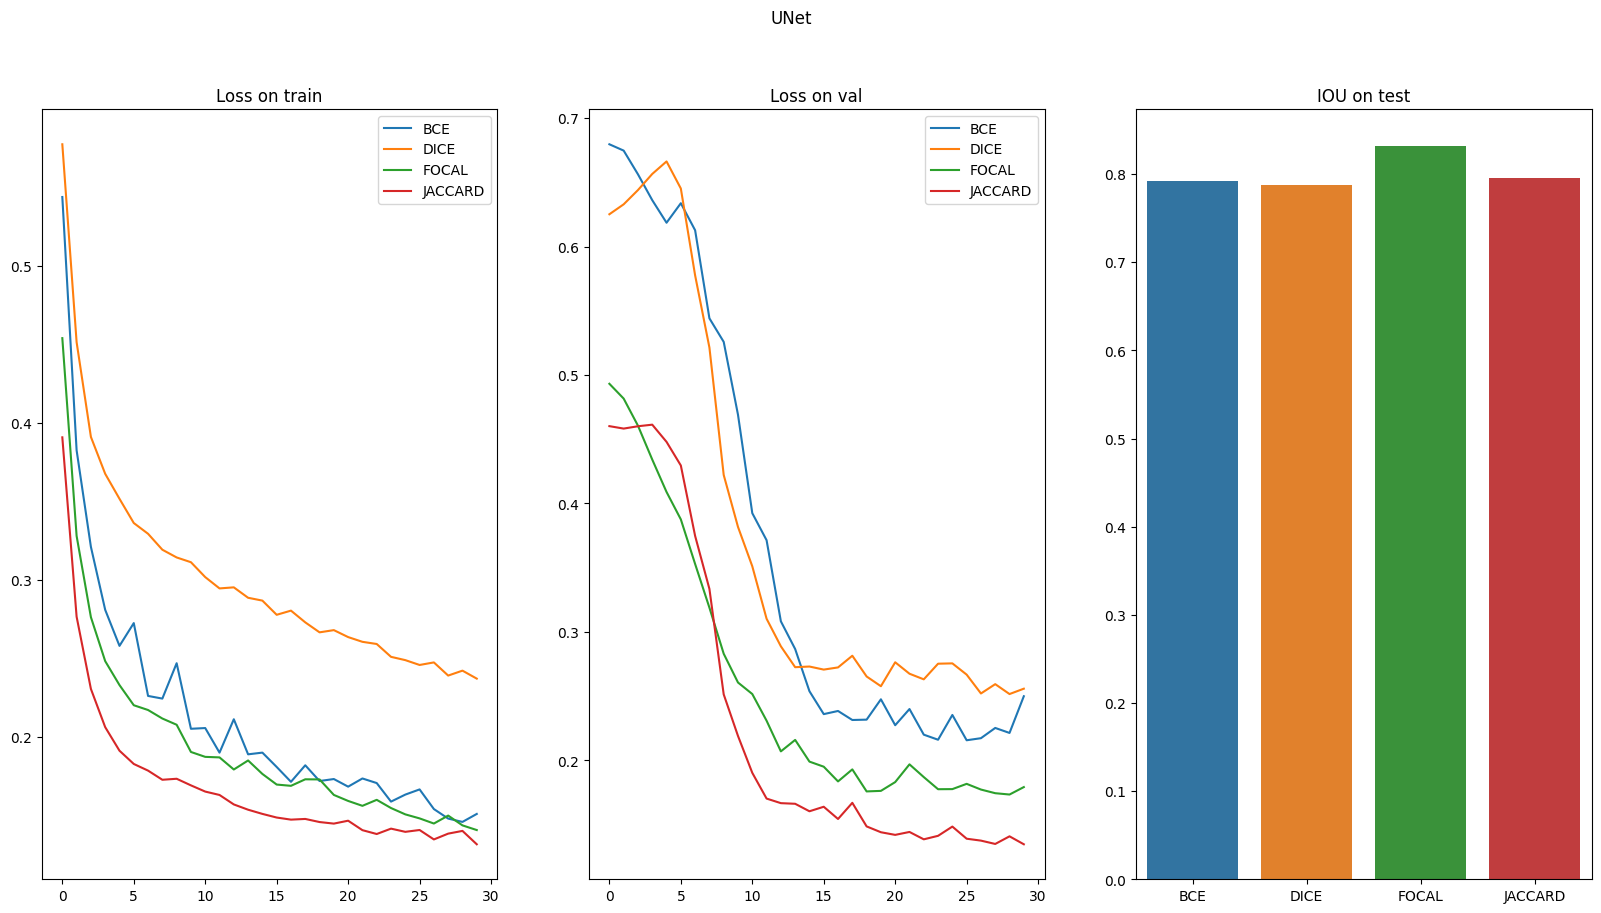

In [ ]:
metr(unet_models, "UNet")

Рассмотрим уже другую, архитектуру - *UNET*, что касается функциий потерь, то тут практически без изменеий лидеры по прежнему *Jaccard* и *Focal*, но take a look at метрику, мы видим прирост, а именно *Focal* перевалил за 0.8, кроме того нельзя не отметить "более плавную" сходимость функций потерь на начальных эпохах и их выход на "плато" после 15 эпохи

**Победители**


1. *Jaccard*
2. *Focal*



In [6]:
unet2_models = {
    'BCE': history_unet2_bce,
    'DICE': history_unet2_dice,
    'FOCAL': history_unet2_focal,
    'JACCARD': history_unet2_jac
}

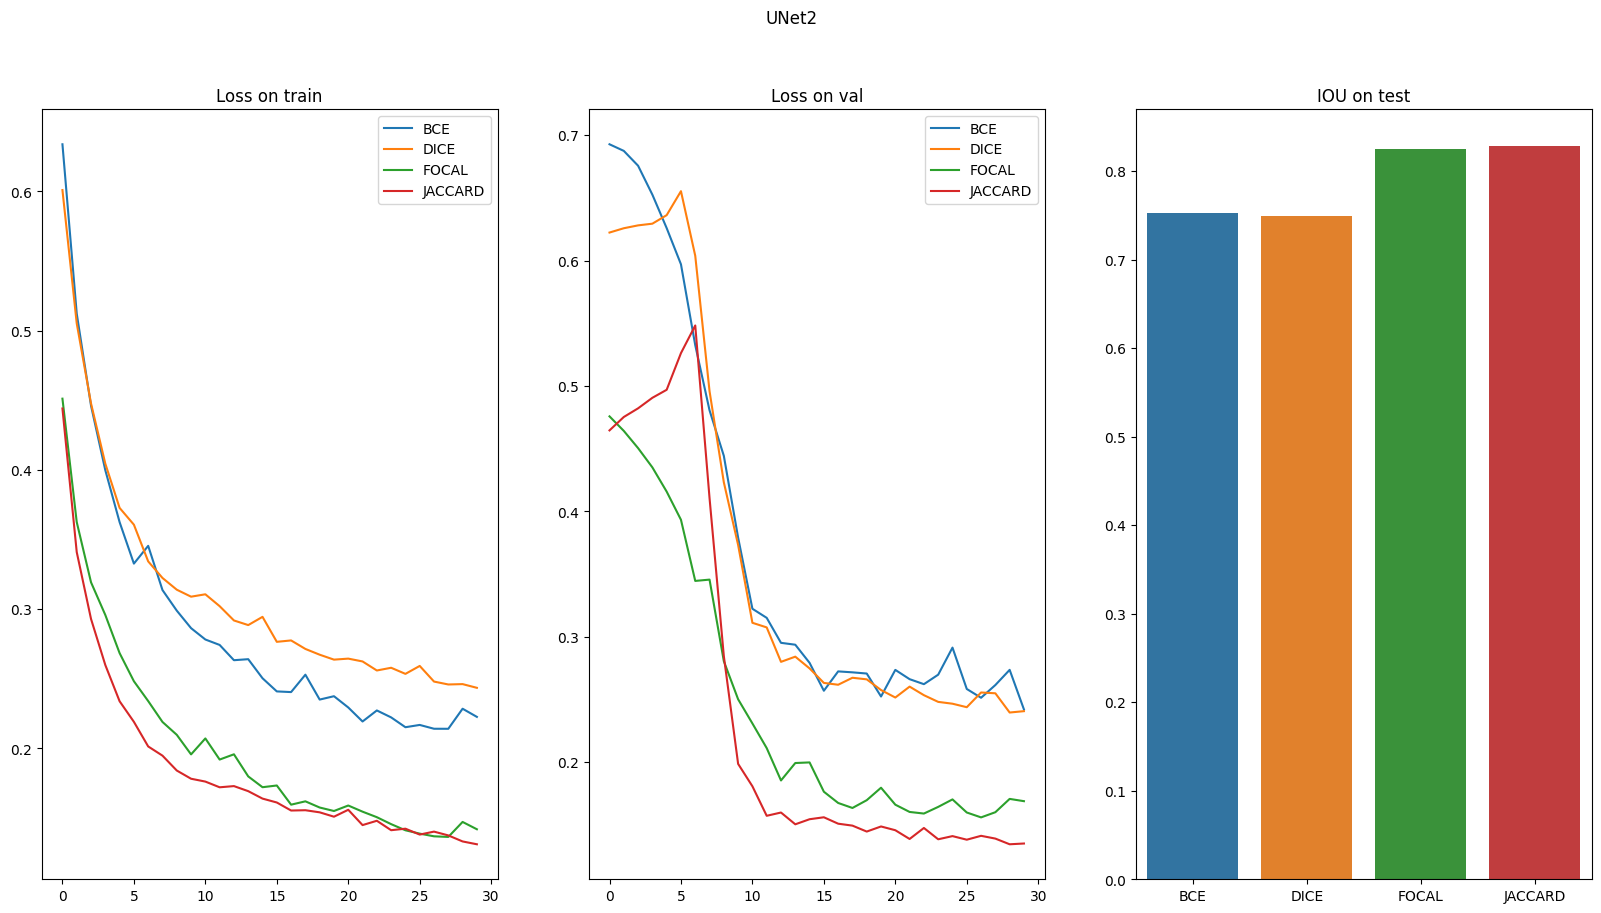

In [11]:
metr(unet2_models, "UNet2")

Взглянем на улучшенную версию - *UNet2*. *Jaccard* уменьшил свой лосс на тестовой выборке, на полноса обогнал *Focal* по метрике, поэтому из всего разнообразия моделей и функций потерь победиетелем объявляется ***Jaccard*** в паре с ***UNet2***